<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQk4anYFFsY3OTqb6RP4oTBhqPM0P1u80tSRA&usqp=CAU" width=75 height=50>

*Algirdas Laukaitis*

<br><br>

---



# PART 1

<font color='SeaGreen'>Download and prepare the CIFAR10 dataset</font>        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/PICOL_Download.svg/1024px-PICOL_Download.svg.png" width=100 height=100>


In [1]:
!kaggle datasets download -d aniruddhsharma/structural-defects-network-concrete-crack-images

Dataset URL: https://www.kaggle.com/datasets/aniruddhsharma/structural-defects-network-concrete-crack-images
License(s): other
 98% 496M/506M [00:09<00:00, 37.4MB/s]
100% 506M/506M [00:09<00:00, 56.8MB/s]


In [1]:
import zipfile
import os

zip_file_path = '/content/structural-defects-network-concrete-crack-images.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if not os.path.exists('/content/data'):
      zip_ref.extractall('/content/data')
    else:
      print("Data folder already exists")

Data folder already exists


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Create dataframe of images and labels

In [3]:
from PIL import Image
df = pd.DataFrame(columns=['image', 'label'])

data_directory = Path('/content/data')
image_amount = 1000

for folder in data_directory.iterdir():
  material = folder.name + '-'
  for material_state in folder.iterdir():  # material_state cracked / non-cracked
    label = material+material_state.name
    i = 0
    print(f'Currently processing: {label}')
    for image in material_state.iterdir():
      try:
        with Image.open(image) as img:
          if i >= image_amount:
            break
          i += 1
          df = pd.concat([df, pd.DataFrame({'image': [np.array(img)], 'label': [label]})], ignore_index=True)
      except Exception as e:
        print(f"Error processing image {image.name}: {e}")
        continue

Currently processing: Walls-Non-cracked
Currently processing: Walls-Cracked
Currently processing: Decks-Non-cracked
Currently processing: Decks-Cracked
Currently processing: Pavements-Non-cracked
Currently processing: Pavements-Cracked


In [22]:
df.label.value_counts()

,count
label,
Walls-Non-cracked,1001
Walls-Cracked,1001
Decks-Non-cracked,1001
Decks-Cracked,1001
Pavements-Non-cracked,1001
Pavements-Cracked,1001


In [25]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(df.image, df.label, test_size=0.2, random_state=42)

In [26]:
#@title Normalizing the pixel values is crucial, ensuring our data is ready for the challenges ahead

train_images, test_images = train_images / 255.0, test_images / 255.0

<br><br>

---
###<font color='SeaGreen'>Let's plot the first 100 images </font>


In [28]:
train_labels

,label
5632,Pavements-Cracked
5837,Pavements-Cracked
2348,Decks-Non-cracked
5332,Pavements-Cracked
5661,Pavements-Cracked
...,...
3772,Decks-Cracked
5191,Pavements-Cracked
5226,Pavements-Cracked
5390,Pavements-Cracked


NameError: name 'class_names' is not defined

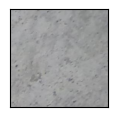

In [27]:
#@title  Let's navigate through a hundred images from CIFAR-10 to ensure our data is intact. It's essential to know what we're up against.
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
train_images[2]

array([[[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       ...,

       [[0.44313725, 0.47058824, 0.43921569],
        [0.43529412, 0.4627451 , 0.43529412],
        [0.41176471, 0


<br><br><br><br>


# <font color='SeaGreen'>Convolutional Neural Network</font>        <img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png" width=500 height=150>

<br><br>

---
###<font color='SeaGreen'>Step 2. Model </font>

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))


model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model.summary() # Number of parameters per filter: (filter size * input channels) + 1 (bias)  ; Total parameters: number of filters * parameters per filter



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 10)          │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │           5,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,282 (426.88 KB)

 Trainable params: 109,282 (426.88 KB)

 Non-trainable params: 0 (0.00 B)

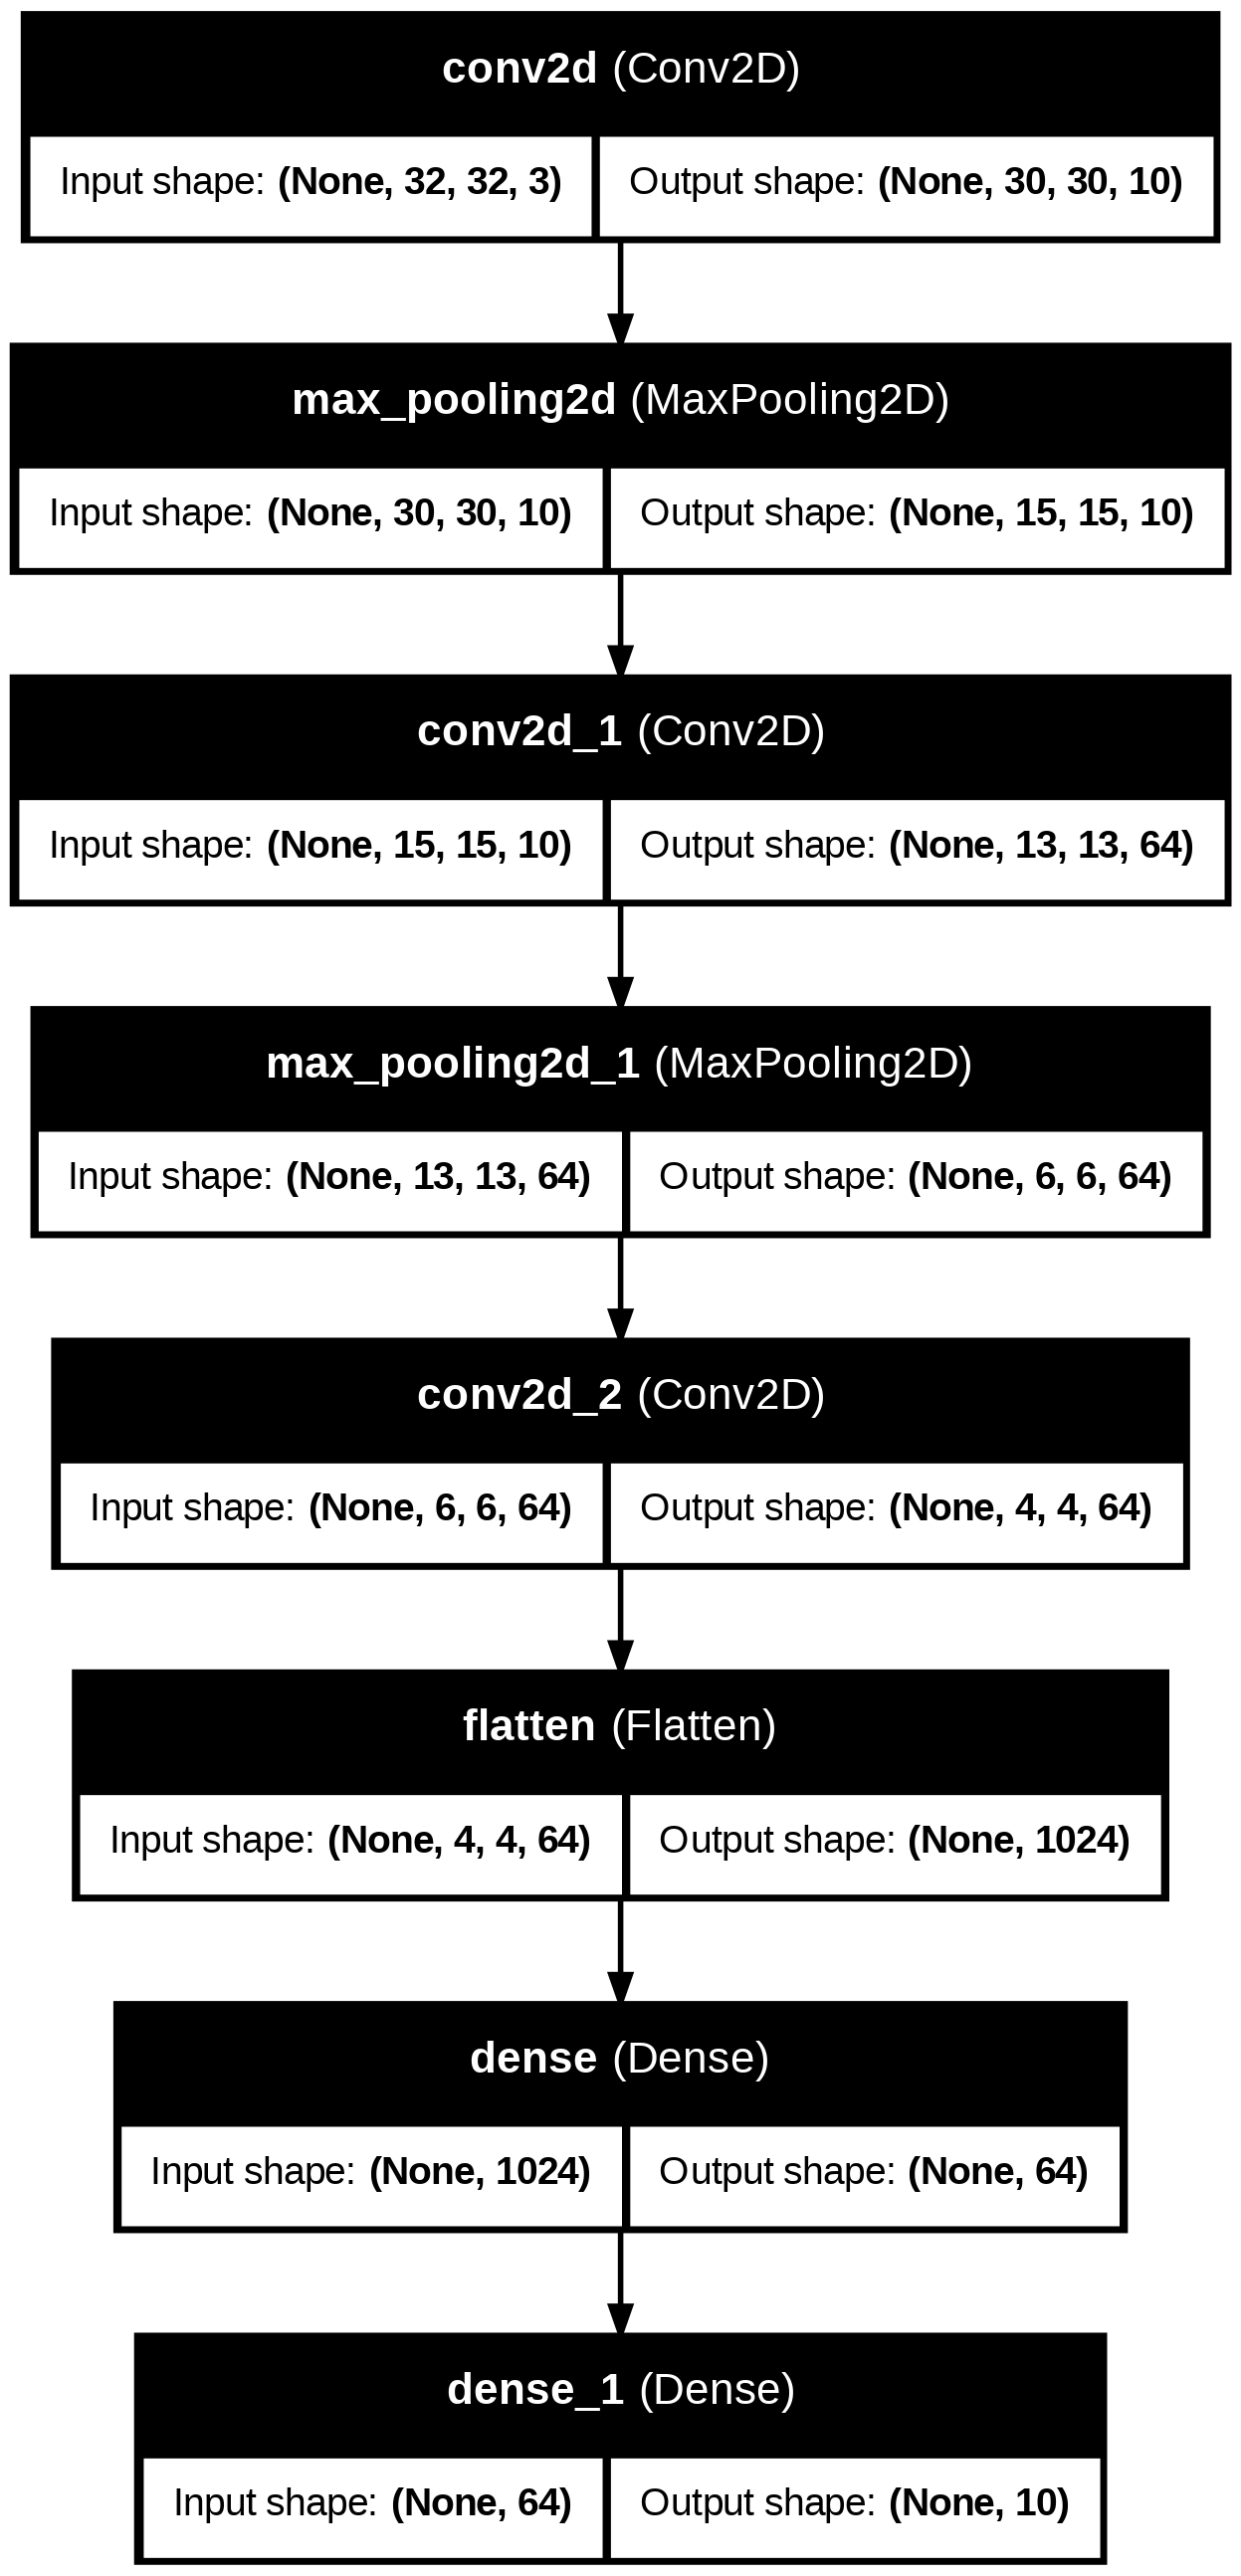

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

<br><br>

---
###<font color='SeaGreen'>Step 3. Train and evaluate the model</font>

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.3520 - loss: 1.7606 - val_accuracy: 0.5474 - val_loss: 1.2663
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5580 - loss: 1.2403 - val_accuracy: 0.5940 - val_loss: 1.1336
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6151 - loss: 1.0781 - val_accuracy: 0.6356 - val_loss: 1.0279
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6601 - loss: 0.9632 - val_accuracy: 0.6545 - val_loss: 0.9869
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6841 - loss: 0.8957 - val_accuracy: 0.6659 - val_loss: 0.9519
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7070 - loss: 0.8344 - val_accuracy: 0.6791 - val_loss: 0.9211
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7212 - loss: 0.7899 - val_accuracy: 0.6921 - val_loss: 0.9020
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7425 - loss: 0.7256 

####<font color='SeaGreen'>Evaluate the model</font>

313/313 - 0s - 2ms/step - accuracy: 0.6966 - loss: 0.8953
0.6966000199317932


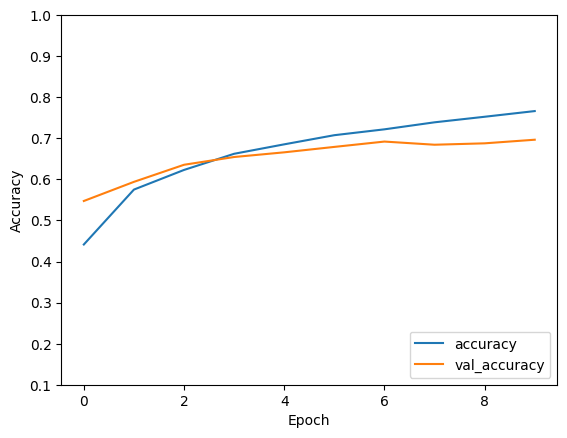

In [ ]:
#@title Behold, the rise of Convolutional Neural Networks! By harnessing the power of convolutional layers, we achieve a remarkable 70% accuracy.

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)


<br><br>

---
# PART 2








<font color='SeaGreen'>Visualizing Filters and Feature Maps</font> <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" width=200 height=200>


The simplest way to visualize learned filters in a neural network is to plot them as two-dimensional images. These filters, essentially weights, have a spatial relationship due to their two-dimensional structure. To view these filters, you can access the model's layers and identify convolutional layers with 'conv' in their names. Each convolutional layer has filter weights and bias values, which you can retrieve and examine. Typically, convolutional layers use 3x3 filters, and it's essential that the filter depth matches the input's channel depth. This process helps you understand the model's filter shapes and their compatibility with input channels.


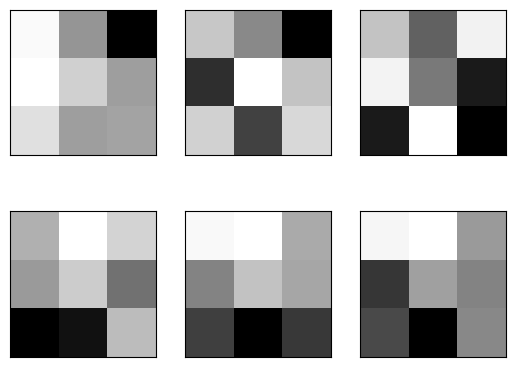

In [ ]:
#@title These are the building blocks of our neural networks.

filters, biases = model.layers[0].get_weights()

ix = 1
for filter_i in range(2):
	filter_tmp = filters[:, :, :, filter_i]
	for channel_j in range(3):  # plot each channel separately
		ax = plt.subplot(2, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(filter_tmp[:, :, channel_j], cmap='gray')
		ix += 1
plt.show()

In [ ]:
#@title 📤 Let's delve into filter outputs.

model_layers_0 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)  # redefine model to output right after the first hidden layer

In [ ]:

img = train_images[1]  # load the image
img = np.expand_dims(img, axis=0)  # expand dimensions so that it represents a single 'sample'


feature_maps = model_layers_0.predict(img)  # get feature map for first hidden layer

#plt.figure(figsize=(5, 5));plt.imshow(train_images[1]);plt.axis('off');plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


In [ ]:
transposed_img = np.transpose(train_images[1] , (2, 0, 1))
np.set_printoptions(threshold=np.inf)
for row in transposed_img[0]:
    formatted_row = ["{:0.2f}".format(element) for element in row]
    print(" ".join(formatted_row))

0.60 0.49 0.41 0.40 0.49 0.61 0.67 0.71 0.56 0.44 0.42 0.43 0.48 0.50 0.71 0.85 0.82 0.65 0.64 0.62 0.45 0.40 0.37 0.35 0.28 0.24 0.22 0.30 0.37 0.36 0.34 0.31
0.55 0.57 0.49 0.49 0.59 0.60 0.68 0.70 0.53 0.43 0.52 0.64 0.75 0.85 0.94 0.96 0.95 0.93 0.92 0.89 0.56 0.38 0.39 0.37 0.35 0.31 0.25 0.33 0.36 0.38 0.30 0.28
0.55 0.55 0.45 0.58 0.54 0.52 0.67 0.70 0.67 0.75 0.86 0.92 0.90 0.94 0.96 0.96 0.91 0.88 0.92 0.95 0.69 0.40 0.40 0.35 0.40 0.37 0.25 0.33 0.35 0.31 0.27 0.26
0.53 0.54 0.48 0.52 0.59 0.71 0.80 0.82 0.82 0.80 0.70 0.66 0.64 0.49 0.70 0.94 0.91 0.83 0.76 0.79 0.72 0.47 0.36 0.37 0.36 0.30 0.27 0.38 0.35 0.30 0.25 0.28
0.51 0.55 0.53 0.73 0.84 0.79 0.64 0.59 0.54 0.47 0.37 0.42 0.42 0.13 0.51 0.95 0.93 0.92 0.83 0.76 0.52 0.49 0.40 0.38 0.35 0.31 0.35 0.37 0.27 0.28 0.27 0.34
0.53 0.53 0.50 0.60 0.54 0.47 0.36 0.38 0.40 0.38 0.34 0.47 0.38 0.18 0.46 0.80 0.89 0.91 0.93 0.93 0.65 0.49 0.49 0.36 0.35 0.31 0.34 0.38 0.30 0.26 0.32 0.36
0.57 0.49 0.35 0.33 0.34 0.33 0.29 0.31 

IndexError: index 10 is out of bounds for axis 3 with size 10

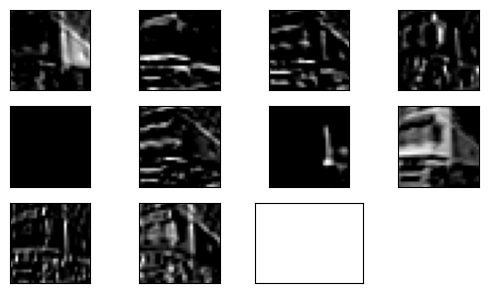

In [ ]:
#@title 📍 feature maps created by the filters from the first layer of our trained CNN. Each filter extracts a unique facet.

ix = 1
for _ in range(4):
  for _ in range(4):
    if ix > 32:
      break
    # specify subplot and turn of axis
    ax = plt.subplot(4, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1



In [ ]:
train_images[1].shape

In [ ]:
filter = filters[:,:,:,2]
filter.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_images[1] is your input image (32x32x3) and filter has shape (3, 3, 3)
input_image = train_images[1]


# Perform convolution
feature_map = np.zeros((input_image.shape[0] - filter.shape[0] + 1, input_image.shape[1] - filter.shape[1] + 1))

for i in range(feature_map.shape[0]):
    for j in range(feature_map.shape[1]):
        feature_map[i, j] = np.sum(input_image[i:i+filter.shape[0], j:j+filter.shape[1], :] * filter)

# Display the feature map
plt.imshow(feature_map, cmap='gray')
plt.title("Feature Map")
plt.axis('off')
plt.show()


In [ ]:
plt.imshow(feature_maps[0, :, :, 2], cmap='gray')

In [ ]:
bias = biases[2]
bias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_images[1] is your input image (32x32x3) and filter has shape (3, 3, 3)
input_image = train_images[1]


# Perform convolution
feature_map = np.zeros((input_image.shape[0] - filter.shape[0] + 1, input_image.shape[1] - filter.shape[1] + 1))

for i in range(feature_map.shape[0]):
    for j in range(feature_map.shape[1]):
        feature_map[i, j] = np.sum(input_image[i:i+filter.shape[0], j:j+filter.shape[1], :] * filter) + bias


# Apply ReLU activation
feature_map[feature_map < 0] = 0

# Display the feature map
plt.imshow(feature_map, cmap='gray')
plt.title("Feature Map")
plt.axis('off')
plt.show()


In [ ]:
feature_map_tmp = feature_maps[0, :, :, 2]
print(feature_map_tmp.shape)
print(feature_map_tmp[:6,:6])


In [ ]:
print(feature_map.shape)
print(feature_map[:6,:6])



<br><br><br><br><br><br>

---
#<font color='SeaGreen'>Image classification with Multilayer perceptron</font> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/250px-Colored_neural_network.svg.png" width=150 height=150>






<br><br>

---
###<font color='SeaGreen'>Step 2. Model. Multilayer perceptron</font>

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32, 32,3)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

In [ ]:
#@title Let's display the architecture of  model:

model.summary()



<br><br>

---
###<font color='SeaGreen'>Step 3. Train and evaluate the model</font>

In [ ]:
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

####<font color='SeaGreen'>Evaluate the model</font>



In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')



In [ ]:
#@title We've attempted a simple neural network, but it only achieved 40% accuracy, demonstrating the inefficiency of such basic models"

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)